<p><strong>Air SAS Beamforming Code</strong></p>
<p>This code is used to construct the 2D Image from SAS Setup</p>

<em>If there are issues with your code or image is not the best quality look at these:</em>
<ol>
<li>Check to make sure the shape of arrays are correct</li>
<li>Check that you changed the Group delay, which should be provided in the csv files from data collection in file "SysParams"</li>
<li>Ensure you set up pixel distribution correctly, either of your own or with the file provided in the code</li>
<li>Ensure to correct the coordinates if Tx or Rx change from given data</li>
<li>Check that the values in the LFM Function match the values from Labview</li>
<li>Check if C or speed of sound is correct for testing enviroment</li>

<strong>Setup of Data:</strong>
<ul>
<li>Importation of needed packages</li>
<li>Processing the CSV files from data collection to be properly read and plotted</li>
<li>Load pixels and ensure that the parameters are correct -> 2 by 2</li>
<li>Get Coordinates from Tx and Rx</li>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch
import pandas as pd
import glob
import os, sys
import math

In [2]:
csv_directory = r'C:\Users\Dell\Downloads\Research\Test_run\Test_run_360'
background_directory = r"C:\Users\Dell\Downloads\Research\Test_run\Test_run_background"

background = []
data = []

#Convert the data from the background data
for file_name in glob.glob(os.path.join(background_directory, "*.csv")):
    if "Flight" in file_name:
        file_path = os.path.join(background_directory, file_name)
        
        # Load the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        #The background will be a NumPy List
        numpy_array = df.to_numpy()[:,0]
        background.append(numpy_array)


#Convert the data from the recorded object
for file_name in glob.glob(os.path.join(csv_directory, "*.csv")):
    if "Flight" in file_name:
        file_path = os.path.join(csv_directory, file_name)
        
        # Load the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Convert DataFrame to NumPy list
        numpy_array_data = df.to_numpy()[:,0]
        data.append(numpy_array_data)

#Convert the list to a NumPy array
#The data will be a NumPy Array
data_array = np.array(data)

#To get desired shape of (999, 360) transpose the data
data_array = data_array.T

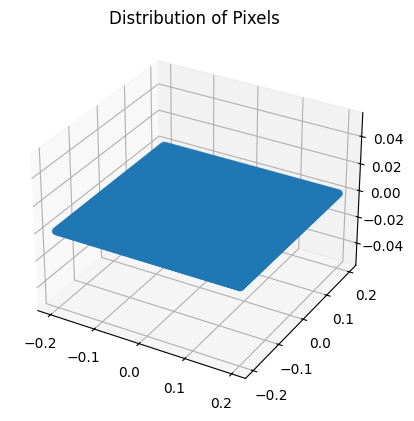

In [3]:
#Keep this file the same, it will have the correct parameters for the Air SAS setup in the lab
#Unless you need other parameters for the pixels
pixels = np.load(r'C:\Users\Dell\Downloads\Research\Beamforming code and data\pixels.npy')

#Visualize the distribution of pixels
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pixels[:, 0], pixels[:, 1], pixels[:, 2])
plt.title('Distribution of Pixels')
plt.show()


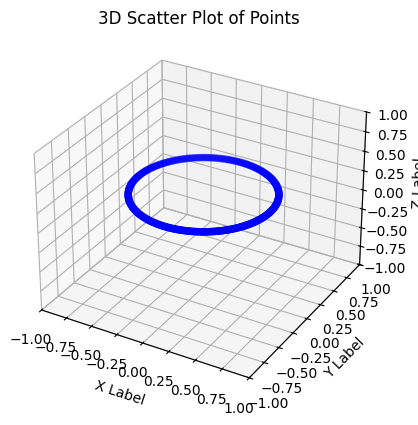

In [4]:

# Function to generate coordinates along a circle
def generate_circle_coordinates(tx, rx, radius_tx, radius_rx):
    # Initialize coordinate array
    new_tx = np.zeros((360, 3))  
    new_rx = np.zeros((360, 3))

    for i in range(1, 361):  # Loop over all angles (degrees) from 1 to 360
        theta = np.radians(i)  # Convert angle to radians

        # Coordinates for the circle in XY plane (X, Y)
        x_tx = radius_tx * np.cos(theta)
        y_tx = radius_tx * np.sin(theta)

        # Set Z coordinate based on the tx position
        z_tx = tx[2]  # Z is from the tx position

        x_rx = radius_rx * np.cos(theta)
        y_rx = radius_rx * np.sin(theta)
        z_rx = rx[2]

        # Set the coordinates in the new_tx array
        new_tx[i - 1] = np.array([x_tx, y_tx, z_tx])  # Store in array
        new_rx[i - 1] = np.array([x_rx, y_rx, z_rx])

    return new_tx, new_rx

tx = np.array([0,0.63,.23])
rx = np.array([0,0.63,0.22])

new_tx, new_rx = generate_circle_coordinates(tx, rx, 0.63, 0.63)

x = new_tx[:, 0]
y = new_tx[:, 1]
z = new_tx[:, 2]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x, y, z, c='b', marker='o')

# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_xlim([-1, 1])  # Set x-axis limit
ax.set_ylim([-1, 1])  # Set y-axis limit
ax.set_zlim([-1, 1])  # Set z-axis limit

# Set title
ax.set_title('3D Scatter Plot of Points')

# Show the plot
plt.show()

<strong>LFM</strong> 
<ul>
<li>Function to generate the chirp sent out during testing</li>
<li>Plot of LFM function for verification</li>

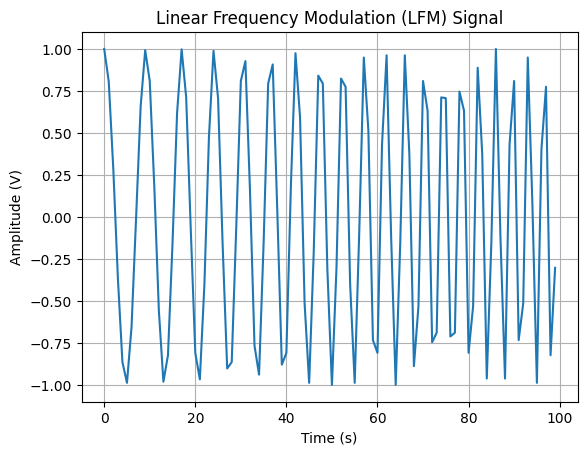

In [5]:

# LFM function
def generate_lfm_signal(f_start=10E+3, f_stop=30e3, fs=100e3, sweep_length=0.001, A=1):
    # Time vector
    t = np.linspace(0, sweep_length, int(fs * sweep_length), endpoint=False)

    # Frequency sweep rate (chirp rate)
    k = (f_stop - f_start) / sweep_length

    # Generate LFM signal
    s = A * np.cos(2 * np.pi * (f_start * t + 0.5 * k * t**2))

    return s

# Plot the LFM signal
plt.plot(generate_lfm_signal())
plt.title('Linear Frequency Modulation (LFM) Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.grid(True)
plt.show()

<strong>Group Delay and Background Adjustments</strong>
<ul>
<li>Correct Group Delay Function</li>
<li>Mean Background to be taken from all data</li>
<li>Corrected signal once group delay and background are included</li>

In [6]:
def correct_group_delay(wfm, gd, fs):
    assert np.isreal(wfm).all()
    num_samples = wfm.shape[-1]
    df = fs / num_samples
    f_ind = np.linspace(0, int(num_samples - 1), num=int(num_samples),
                        dtype=np.float64)
    f = f_ind * df
    f[f > (fs / 2)] -= fs
    w = (2 * math.pi * f)

    tau = gd / fs

    phase = np.array([tau * w])

    complex_phase = np.zeros_like(phase) + 1j * phase

    pr = np.exp(complex_phase)

    wfm_correct_ifft = np.fft.fft(wfm) * pr

    wfm_correct = np.fft.ifft(wfm_correct_ifft, axis=1).real

    return wfm_correct

In [7]:
background = np.array(background)
mean_bg = np.mean(background, axis=0)

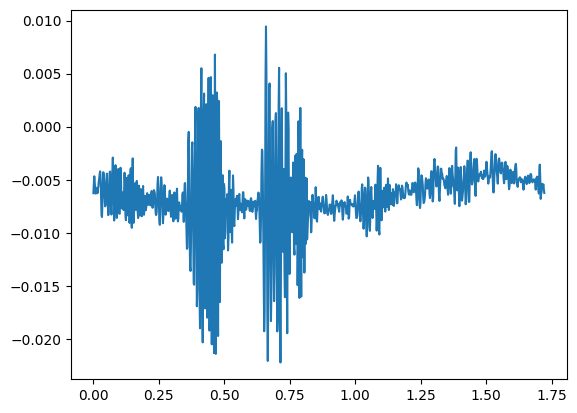

In [8]:
# Plot measurements and measurements transposed
x = data_array.T

#Will have to update the middle value with the group delay provided by the data in csv files
x = correct_group_delay(x, 62.3, 100000)
bg = correct_group_delay(mean_bg, 62.3, 100000)

#Subtract bg from all data
x = x - bg

t = np.linspace(0,0.001,999) # t is for time
c = 344.351

dist = (10*t*c/(2))

plt.plot(dist, x[0])
plt.show()

<strong>Match Filtering</strong>
<ul>
<li>Calling LFM Function back</li>
<li>Computing the Analytical Signal</li>
<li>Plot of Analytical signal with real and imaginary signal</li>

In [9]:
# Generate the LFM signal
lfm_signal = generate_lfm_signal()

# Match filter the measured signals in frequency domain and compute the analytic signal
x_hilbert = signal.hilbert(x)
x_hilbert_fft = np.fft.fft(x_hilbert)

# Ensure LFM_signal has the same length as your measurements or zero-pad if necessary
lfm_signal_padded = np.pad(lfm_signal, (0, max(0, x.shape[1] - len(lfm_signal))), mode='constant')
t_fft = np.fft.fft(lfm_signal_padded)

# Compute the inverse FFT of the product of FFTs
x_analytic = np.fft.ifft(x_hilbert_fft * np.conj(t_fft[:x.shape[1]]))


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


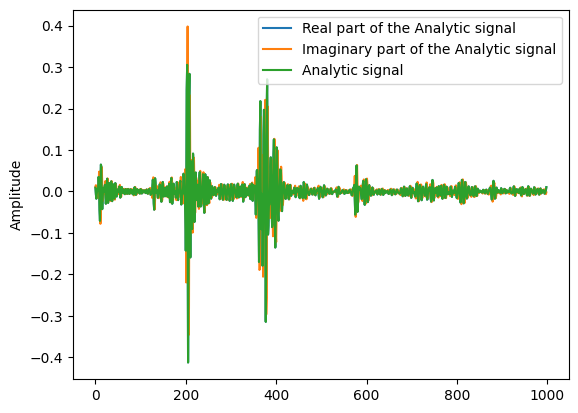

In [10]:
# Plot the Analytic signal plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.plot(x_analytic[0].real,label = 'Real part of the Analytic signal')
plt.plot(x_analytic[0].imag,label = 'Imaginary part of the Analytic signal')
plt.plot(x_analytic[0],label = 'Analytic signal')
plt.legend()
plt.show()

<strong>Beamforming</strong>
<ul>
<li>Bring coordinates Tx and Rx back to find distances</li>
<li>Use distance and speed of sound to find time of flight</li>
<li>Sinc Interpolation</li>
<li>Reshape to form 2D image</li>

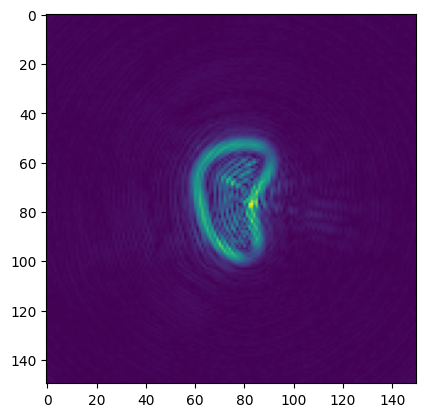

In [11]:
# Declare speed of sound and sampling frequency as constants
#Change if needed
c = 344.351
Fs = 100000

tx_coords = new_tx
rx_coords = new_rx

# Beamform the image
output = np.zeros((1,22500)) #22500 = 150x150 pixel resolution
for i in range(tx_coords.shape[0]):
  d1 = (np.sqrt(np.sum((pixels - tx_coords[i])**2,1)))
  d2 = (np.sqrt(np.sum((pixels - rx_coords[i])**2,1)))
  tof = ((d1+d2)/c)*Fs
  # sinc interpolation
  sinc_interp = np.array([np.sinc((tof - j)) for j in range(999)])
  sinc_interp = sinc_interp.T
  # sampling analytic signal and summing values at the pixels
  output = output + np.sum(x_analytic[i,:][None,:]*sinc_interp,1)
# Reshape output array to form 2-D image
output = output.reshape(150,150)
# Display the beamformed image
plt.imshow(np.abs(output))
plt.show()